In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
print(os.listdir("input"))

['movie-review-sentiment-analysis-kernels-only']


In [3]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
df = pd.read_csv('input/movie-review-sentiment-analysis-kernels-only/train.tsv', delimiter='\t')
df = df[['Phrase', 'Sentiment']]

pd.set_option('display.max_colwidth', -1)
df.head(3)

,Phrase,Sentiment
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,A series of escapades demonstrating the adage that what is good for the goose,2
2,A series,2


In [5]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()

df['text'] = df['Phrase'].apply(clean_str)

In [6]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4    9206 
0    7072 
Name: Sentiment, dtype: int64

In [7]:
df_0 = df[df['Sentiment'] == 0].sample(frac=1)
df_1 = df[df['Sentiment'] == 1].sample(frac=1)
df_2 = df[df['Sentiment'] == 2].sample(frac=1)
df_3 = df[df['Sentiment'] == 3].sample(frac=1)
df_4 = df[df['Sentiment'] == 4].sample(frac=1)

# we want a balanced set for training against - there are 7072 `0` examples
sample_size = 7072

data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_2.head(sample_size), df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

In [8]:
data['l'] = data['Phrase'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 9.102997737556562
max length of sentence: 52
std dev length of sentence: 8.01207564931148


In [9]:
sequence_length = 52
max_features = 20000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(data['Phrase'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(data['Phrase'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(data['Sentiment']).values

# where there isn't a test set, Kim keeps back 10% of the data for testing, I'm going to do the same since we have an ok amount to play with
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 3536


# Model1 : Random embeddings

In [10]:
embedding_dim = 200 # Kim uses 300 here
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# use a random embedding for the text
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# Note the relu activation which Kim specifically mentions
# He also uses an l2 constraint of 3
# Also, note that the convolution window acts on the whole 200 dimensions - that's important
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 52, 200)      4000000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 52, 200, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 1, 100)   60100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
batch_size = 32 # Kim uses 50 here, I have a slightly smaller sample size than num
history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 28641 samples, validate on 3183 samples
Epoch 1/30
28641/28641 [==============================] - 162s 6ms/step - loss: 1.6987 - acc: 0.2309 - val_loss: 1.6104 - val_acc: 0.3139
Epoch 2/30
28641/28641 [==============================] - 145s 5ms/step - loss: 1.6047 - acc: 0.2893 - val_loss: 1.5826 - val_acc: 0.2941
Epoch 3/30
28641/28641 [==============================] - 144s 5ms/step - loss: 1.5716 - acc: 0.3159 - val_loss: 1.5368 - val_acc: 0.3424
Epoch 4/30
28641/28641 [==============================] - 144s 5ms/step - loss: 1.5286 - acc: 0.3514 - val_loss: 1.5408 - val_acc: 0.3644
Epoch 5/30
28641/28641 [==============================] - 143s 5ms/step - loss: 1.4992 - acc: 0.3698 - val_loss: 1.5368 - val_acc: 0.3729
Epoch 6/30
28641/28641 [==============================] - 144s 5ms/step - loss: 1.4774 - acc: 0.3849 - val_loss: 1.5077 - val_acc: 0.3673
Epoch 7/30
28641/28641 [==============================] - 147s 5ms/step - l

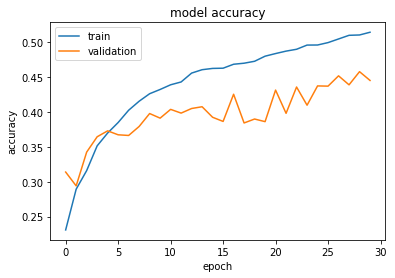

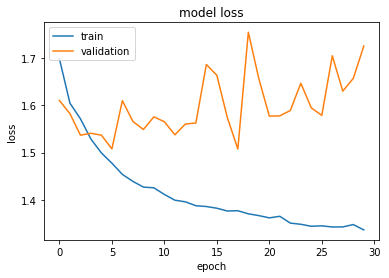

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
y_hat = model.predict(X_test)
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

0.4473981900452489

In [15]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

array([[274, 163,  42, 216,  24],
       [175, 237, 133, 131,  37],
       [ 58, 121, 386,  67,  49],
       [ 76,  94, 120, 201, 236],
       [ 33,  21,  20, 138, 484]], dtype=int64)

# Model2 : Static word2vec

In [19]:
embeddings_index = {}
#f = open(os.path.join('input/glove-global-vectors-for-word-representation', 'glove.6B.200d.txt'), "r")
with open(os.path.join('input/glove-global-vectors-for-word-representation', 'glove.6B.200d.txt'), 'r',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14003 unique tokens.


In [21]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

14004


In [22]:
inputs_2 = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer_2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs_2)

reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_2)

conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_1_2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)
conv_2_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_2)

maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
maxpool_1_2 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_2)
maxpool_2_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_2)

concatenated_tensor_2 = Concatenate(axis=1)([maxpool_0_2, maxpool_1_2, maxpool_2_2])
flatten_2 = Flatten()(concatenated_tensor_2)

dropout_2 = Dropout(0.5)(flatten_2)
output_2 = Dense(units=5, activation='softmax')(dropout_2)
model_2 = Model(inputs=inputs_2, outputs=output_2)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 52, 200)      2800800     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 52, 200, 1)   0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 50, 1, 100)   60100       reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_5 (

In [23]:
batch_size = 32
history_2 = model_2.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 25459 samples, validate on 6365 samples
Epoch 1/30
25459/25459 [==============================] - 49s 2ms/step - loss: 1.8400 - acc: 0.2786 - val_loss: 1.8346 - val_acc: 0.2687
Epoch 2/30
25459/25459 [==============================] - 47s 2ms/step - loss: 1.7725 - acc: 0.2971 - val_loss: 1.7455 - val_acc: 0.2930
Epoch 3/30
25459/25459 [==============================] - 48s 2ms/step - loss: 1.7744 - acc: 0.3125 - val_loss: 1.7743 - val_acc: 0.3819
Epoch 4/30
25459/25459 [==============================] - 45s 2ms/step - loss: 1.7641 - acc: 0.3226 - val_loss: 1.7325 - val_acc: 0.3350
Epoch 5/30
25459/25459 [==============================] - 46s 2ms/step - loss: 1.7470 - acc: 0.3279 - val_loss: 1.7258 - val_acc: 0.3662
Epoch 6/30
25459/25459 [==============================] - 44s 2ms/step - loss: 1.7265 - acc: 0.3416 - val_loss: 1.7600 - val_acc: 0.3288
Epoch 7/30
25459/25459 [==============================] - 44s 2ms/step - loss: 1.7116 - acc: 0.3508 - val_loss: 1.7240 - val_acc:

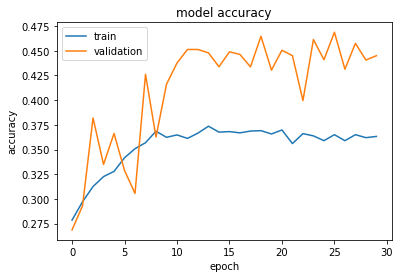

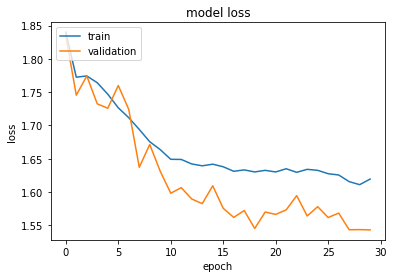

In [24]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
y_hat_2 = model_2.predict(X_test)
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

0.43721719457013575

In [26]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

array([[317, 245, 102,  25,  30],
       [165, 226, 247,  47,  28],
       [ 25,  85, 510,  35,  26],
       [ 36,  89, 287, 143, 172],
       [ 34,  41, 151, 120, 350]], dtype=int64)

# Model3: w2v with trainalbe embeddings

In [27]:
inputs_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

# note the relu activation
conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = Flatten()(concatenated_tensor_3)

dropout_3 = Dropout(0.5)(flatten_3)
output_3 = Dense(units=5, activation='softmax')(dropout_3)

In [28]:
model_3 = Model(inputs=inputs_3, outputs=output_3)
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 52, 200)      2800800     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 52, 200, 1)   0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 50, 1, 100)   60100       reshape_3[0][0]                  
__________________________________________________________________________________________________
conv2d_8 (

In [29]:
batch_size = 32
history_3 = model_3.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 25459 samples, validate on 6365 samples
Epoch 1/30
25459/25459 [==============================] - 107s 4ms/step - loss: 1.8587 - acc: 0.3200 - val_loss: 1.8070 - val_acc: 0.4473
Epoch 2/30
25459/25459 [==============================] - 105s 4ms/step - loss: 1.7440 - acc: 0.4541 - val_loss: 1.6532 - val_acc: 0.5236
Epoch 3/30
25459/25459 [==============================] - 113s 4ms/step - loss: 1.6501 - acc: 0.5039 - val_loss: 1.6366 - val_acc: 0.5362
Epoch 4/30
25459/25459 [==============================] - 108s 4ms/step - loss: 1.5872 - acc: 0.5387 - val_loss: 1.5745 - val_acc: 0.5351
Epoch 5/30
25459/25459 [==============================] - 109s 4ms/step - loss: 1.5429 - acc: 0.5519 - val_loss: 1.6035 - val_acc: 0.5518
Epoch 6/30
25459/25459 [==============================] - 109s 4ms/step - loss: 1.5296 - acc: 0.5606 - val_loss: 1.5476 - val_acc: 0.5365
Epoch 7/30
25459/25459 [==============================] - 109s 4ms/step - loss: 1.5065 - acc: 0.5721 - val_loss: 1.5525 - v

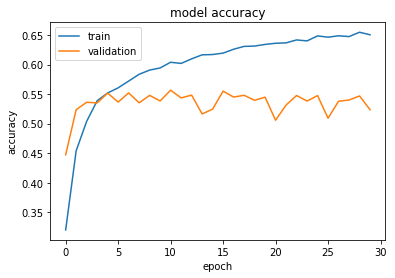

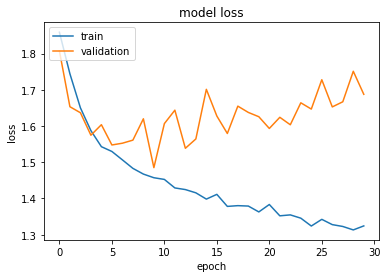

In [30]:
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
y_hat_3 = model_3.predict(X_test)
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))

0.5115950226244343

In [32]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))

array([[384, 306,  20,   8,   1],
       [158, 394, 109,  46,   6],
       [ 26, 150, 400,  96,   9],
       [ 25,  73, 178, 361,  90],
       [ 21,  20,  30, 355, 270]], dtype=int64)

# Model4 : with binary classification

In [33]:
sst2_data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

def merge_sentiments(x):
    if x == 0 or x == 1:
        return 0
    else:
        return 1

sst2_data['Sentiment'] = sst2_data['Sentiment'].apply(merge_sentiments)

sst2_tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
sst2_tokenizer.fit_on_texts(sst2_data['Phrase'].values)

sst2_X = sst2_tokenizer.texts_to_sequences(sst2_data['Phrase'].values)
sst2_X = pad_sequences(sst2_X, sequence_length)

sst2_y = sst2_data['Sentiment'].values

sst2_X_train, sst2_X_test, sst2_y_train, sst2_y_test = train_test_split(sst2_X, sst2_y, test_size=0.1)

In [34]:
inputs_4 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_4 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_4)

reshape_4 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_4)

conv_0_4 = Conv2D(num_filters, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
conv_1_4 = Conv2D(num_filters, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
conv_2_4 = Conv2D(num_filters, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)

maxpool_0_4 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_4)
maxpool_1_4 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_4)
maxpool_2_4 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_4)

concatenated_tensor_4 = Concatenate(axis=1)([maxpool_0_4, maxpool_1_4, maxpool_2_4])
flatten_4 = Flatten()(concatenated_tensor_4)

dropout_4 = Dropout(0.5)(flatten_4)
# note the different activation
output_4 = Dense(units=1, activation='sigmoid')(dropout_4)
model_4 = Model(inputs=inputs_4, outputs=output_4)

# note we're using binary_crossentropy here instead of categorical
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_4.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 52, 200)      2800800     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 52, 200, 1)   0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 50, 1, 100)   60100       reshape_4[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

In [35]:
batch_size = 32
history_4 = model_4.fit(sst2_X_train, sst2_y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 20367 samples, validate on 5092 samples
Epoch 1/30
20367/20367 [==============================] - 89s 4ms/step - loss: 88.7180 - acc: 0.5092 - val_loss: 0.6982 - val_acc: 0.5401
Epoch 2/30
20367/20367 [==============================] - 88s 4ms/step - loss: 0.6974 - acc: 0.5052 - val_loss: 0.6970 - val_acc: 0.5069
Epoch 3/30
20367/20367 [==============================] - 87s 4ms/step - loss: 0.6970 - acc: 0.4986 - val_loss: 0.6966 - val_acc: 0.5106
Epoch 4/30
20367/20367 [==============================] - 87s 4ms/step - loss: 0.6966 - acc: 0.4975 - val_loss: 0.6967 - val_acc: 0.4880
Epoch 5/30
20367/20367 [==============================] - 87s 4ms/step - loss: 0.6955 - acc: 0.5014 - val_loss: 0.6948 - val_acc: 0.4880
Epoch 6/30
20367/20367 [==============================] - 86s 4ms/step - loss: 0.6951 - acc: 0.5054 - val_loss: 0.6959 - val_acc: 0.4929
Epoch 7/30
20367/20367 [==============================] - 87s 4ms/step - loss: 0.6954 - acc: 0.5013 - val_loss: 0.6955 - val_acc

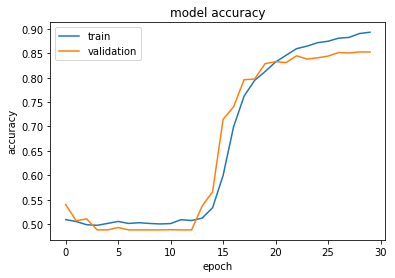

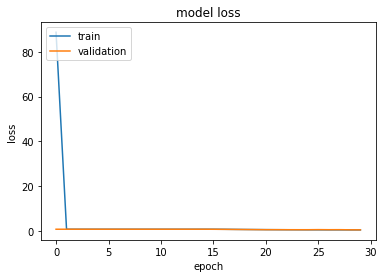

In [36]:
plt.plot(history_4.history['acc'])
plt.plot(history_4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
y_hat_4 = model_4.predict(sst2_X_test)

accuracy_score(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))

0.8586072817249911

In [38]:
confusion_matrix(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))

array([[1170,  240],
       [ 160, 1259]], dtype=int64)

# Result

In [39]:
print("CNN random       : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))))
print("CNN static       : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))))
print("CNN trainable    : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))))
print("Binary trainable : " + str(accuracy_score(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))))

CNN random       : 0.4473981900452489
CNN static       : 0.43721719457013575
CNN trainable    : 0.5115950226244343
Binary trainable : 0.8586072817249911
